The goal of this homework is to try to solve the problem of predicting wine quality from review texts and other properties of the wine. You can find the dataset here:https://www.kaggle.com/zynicide/wine-reviews

For this task, we will only use wine from the United States (only 42% of data).

## Columns Explanation:

* **Designation** - The vineyard within the winery where the grapes that made the wine are from.
* **Points** - The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80).
* **Price** - The cost for a bottle of the wine.
* **Province** - The province or state that the wine is from.
* **region_1** - The wine growing area in a province or state (ie Napa).
* **region_2** - Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank.
* **Taster_name**
* **title** - The title of the wine review, which often contains the vintage if you're interested in extracting that feature.
* **variety** - The type of grapes used to make the wine (ie Pinot Noir).
* **winery** - The winery that made the wine.

In [3]:
import numpy as np
from time import time

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import cross_val_score, GridSearchCV ,cross_val_predict, KFold, StratifiedKFold, ShuffleSplit, train_test_split
from sklearn.linear_model import RidgeCV, LinearRegression, LassoCV, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error


from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from keras.preprocessing.text import Tokenizer 


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
# Create color maps
cmap = ListedColormap(["Red","Green","Blue"])
# cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8","#ffff33","#4daf4a","#ff7f00"])
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

## Bag of Words and simple Features

1.1 Creating a baseline model for predicting wine quality using only non-text features.



In [4]:
df = pd.read_csv('winemag-data-130k-v2.csv')
df = df[df['country']=='US']
print("Dataframe's shape is {} rows and {} columns".format(df.shape[0], df.shape[1]))
df.head()

Dataframe's shape is 54504 rows and 14 columns


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
12,12,US,"Slightly reduced, this wine offers a chalky, t...",NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini


Text(0, 0.5, 'Count')

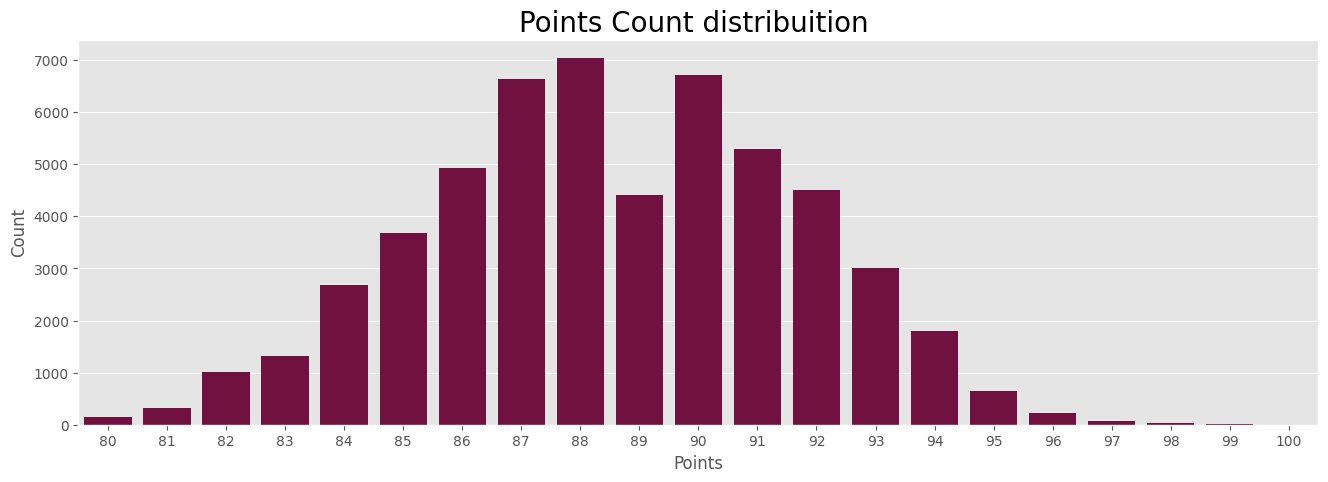

In [5]:
plt.figure(figsize=(16,5))

g = sns.countplot(x='points', data=df, color = sns.xkcd_rgb['wine'])
g.set_title("Points Count distribuition ", fontsize=20) 
g.set_xlabel("Points") 
g.set_ylabel("Count")

The socket I have in the graph means that there are actually two peaks, two distributions.


In a normal distribution, the mean (axis of symmetry) is both the median and common (the middle does not appear to be common)



Text(0, 0.5, 'Count')

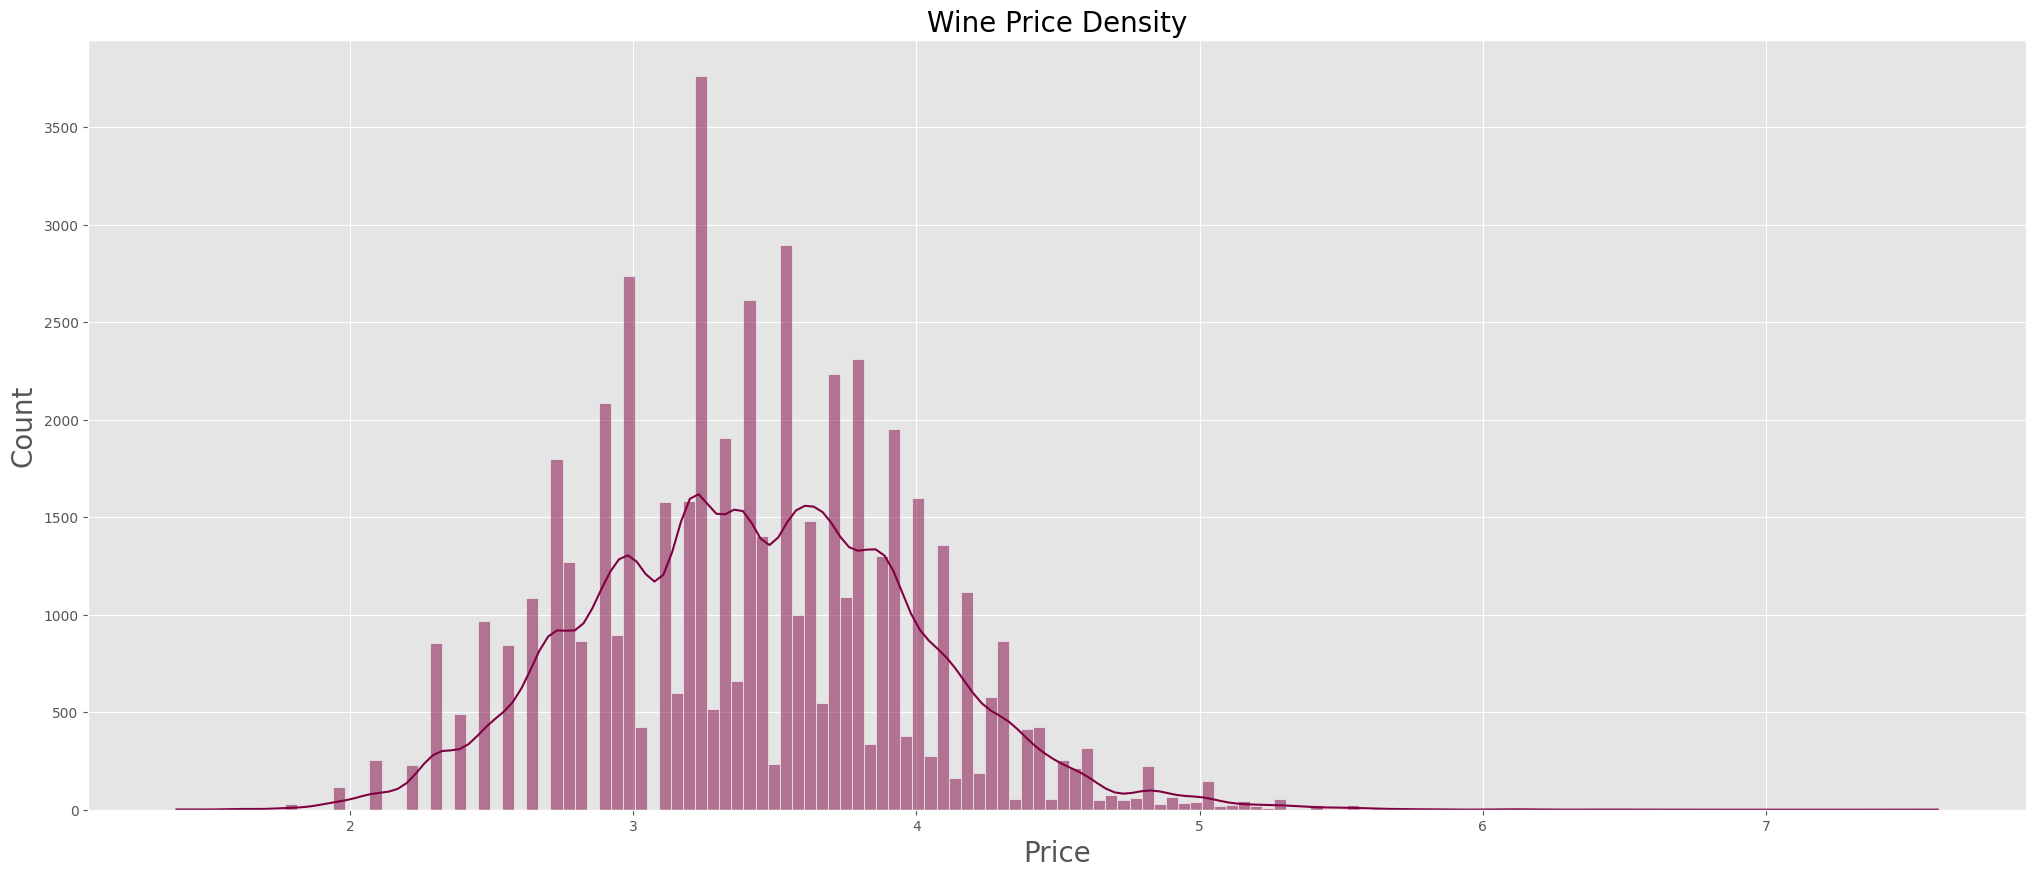

In [6]:
plt.figure(figsize=(25,10))

g = sns.histplot(data = np.log(df['price']), kde = True, color = sns.xkcd_rgb['wine'])
g.set_title("Wine Price Density", fontsize=20) 
g.set_xlabel("Price", fontsize=20) 
g.set_ylabel("Count", fontsize=20)


Taking the logarithm can help to reduce the variability and reveal patterns or outliers in the data that may not be visible otherwise. Additionally, a log transformation can make the data more symmetric, which can help with the interpretation of the histogram plot.

Plotting without the logarithmic function will give us non informatic plot.

<AxesSubplot:xlabel='points', ylabel='log_price'>

<Figure size 1000x1000 with 0 Axes>

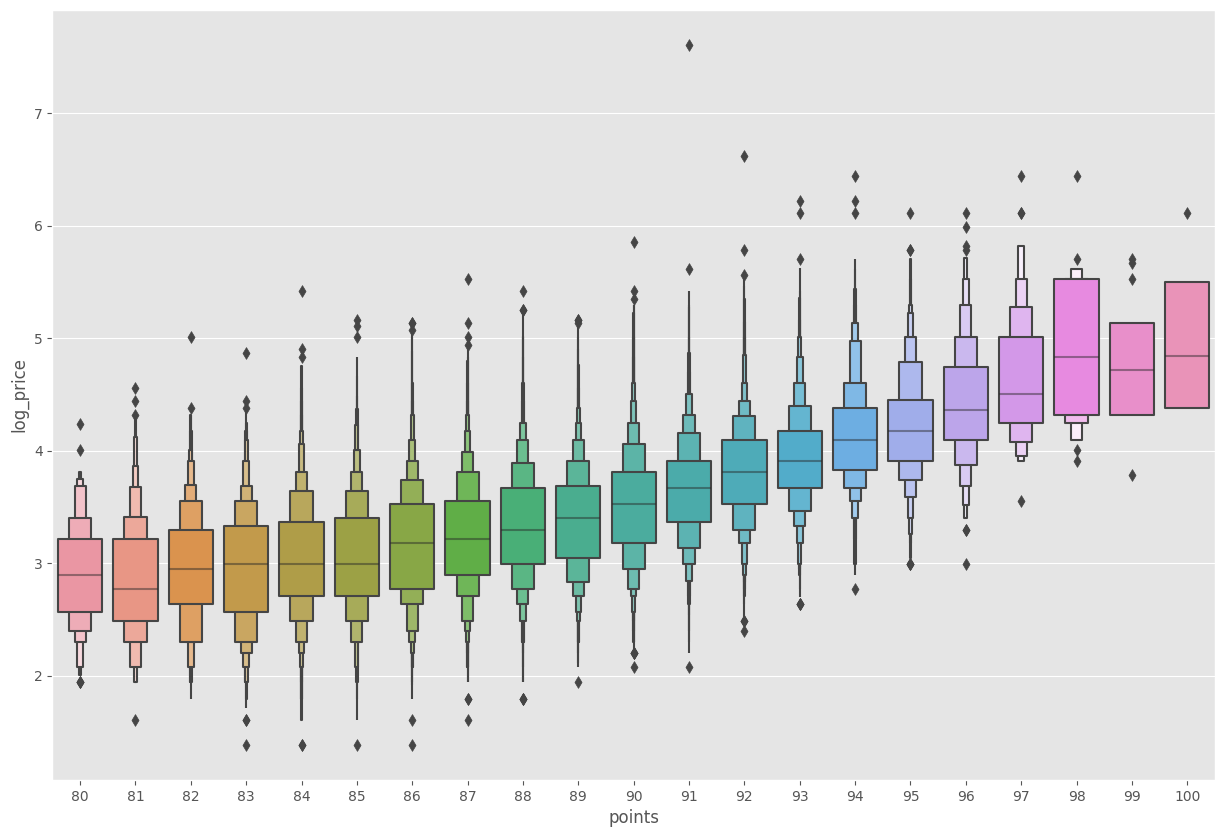

In [7]:
plt.figure(figsize=(10,10))

# # Using the following plot will show us that there is some correlation between those two columns but we don't know 
# # how strong it is and thus, it is not informative enough.
# g = sns.regplot(x='price', y='points', data=df)
# g.set_title("Price vs Points", fontsize=20)
# g.set_xlabel("Price", fontsize=20)
# g.set_ylabel("Points", fontsize=20)


# # Using the following graph will show us the distribution relation between those two columns but as before,
# # it won't be informative enough.

# price_98 = df['price'].quantile(0.98)
# df_98 = df[df['price'] <= price_98]

# g = sns.scatterplot(x='price', y='points', hue='points', data=df_98)
# g.set_title("Price vs Points", fontsize=20)
# g.set_xlabel("Price", fontsize=20)
# g.set_ylabel("Points", fontsize=20)

# # Therefor, we need to put the price under logarithmic scale.
df['log_price'] = np.log(df['price'])
plt.figure(figsize=(15, 10))
sns.boxenplot(data = df, x="points", y="log_price", k_depth="trustworthy")


Text(0.5, 1.0, 'Correlation Heatmap')

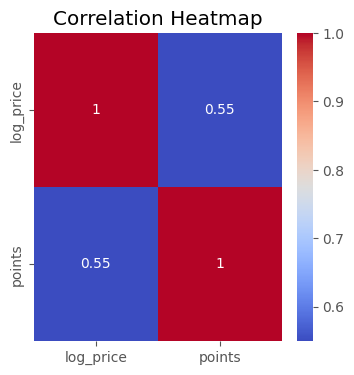

In [8]:
plt.figure(figsize=(4,4))
corr = df[['log_price', 'points']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

In [9]:
print(pd.isna(df['points']).sum())
print(pd.isna(df['price']).sum())

0
239


We can see here that those two features are **moderately correlated**.

In [10]:
# X = df['log_price'].fillna(int(df['log_price'].mean())).copy()
X = df['price'].fillna(int(df['price'].mean())).copy()
y = df['points'].copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42, shuffle=False)
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

In [11]:
cv = KFold(n_splits=5)
ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 10), cv=cv)

ridge_cv.fit(X_train, y_train)

print("Optimal alpha: ", ridge_cv.alpha_)

Optimal alpha:  1000.0


In [12]:

pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1000.0))

# pipeline = make_pipeline(StandardScaler(), LinearRegression())
# pipeline = make_pipeline(StandardScaler(), Lasso(alpha = 0.021544346900318832))
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Mean Squared Error
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                mean_squared_error(y_test, y_test_pred)))
# R-Squared
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

mae = mean_absolute_error(y_test, y_test_pred)
print("Mean Absolute Error: ", mae)

MSE train: 7.411, test: 9.015
R^2 train: 0.224, test: 0.128
Mean Absolute Error:  2.263283327736713


* The mean squared error (**MSE**) is a measure of the average difference between the predicted and actual values. Lower MSE values indicate that the model is making better predictions.

* The **R-squared** value, also known as the coefficient of determination, is a measure of how well the model is able to explain the variability in the target variable. It ranges from 0 to 1, with higher values indicating a better fit. A value of 1 means that the model explains all the variability in the target variable, while a value of 0 means that the model does not explain any of the variability in the target variable.

* Mean Absolute Error (**MAE**) is a measure of the average magnitude of the errors in a set of predictions, without considering their direction. It is the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

1.2 Creating a simple text-based model using a bag-of-words approach and a linear model.


In [13]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,54504.0,NaN,NaN,NaN,65467.828563,37572.539161,2.0,33067.75,65678.5,98191.25,129967.0
country,54504,1,US,54504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,54504,50449,"Cigar box, café au lait, and dried tobacco aro...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
designation,36908,14183,Reserve,1485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,54504.0,NaN,NaN,NaN,88.56372,3.11484,80.0,86.0,88.0,91.0,100.0
price,54265.0,NaN,NaN,NaN,36.573464,27.088857,4.0,20.0,30.0,45.0,2013.0
province,54504,27,California,36247,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_1,54226,264,Napa Valley,4480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_2,50511,17,Central Coast,11065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taster_name,37730,15,Virginie Boone,9537,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df.region_2.unique()

array(['Willamette Valley', nan, 'Napa', 'Sonoma', 'Central Coast',
       'Oregon Other', 'Central Valley', 'North Coast', 'Columbia Valley',
       'California Other', 'Finger Lakes', 'Sierra Foothills',
       'New York Other', 'Long Island', 'Napa-Sonoma', 'Southern Oregon',
       'Washington Other', 'South Coast'], dtype=object)

In [15]:
# The following code calculates the correlation between points and price, grouped by region_2
df.groupby('region_1')[['points','price']].corr().unstack().iloc[:,1]

region_1
Adelaida District      0.470221
Alexander Valley       0.529854
Alta Mesa              0.509119
Amador County          0.346462
Amador-Napa            1.000000
                         ...   
Yamhill County        -1.000000
Yolo County            0.246209
York Mountain          0.659922
Yorkville Highlands    0.543442
Yountville             0.507209
Name: (points, price), Length: 264, dtype: float64

In [16]:
red_df = df.copy()

from textblob import TextBlob

def sentiment_score(text):
    return TextBlob(text).sentiment.polarity

red_df['title_sentiment'] = red_df['title'].apply(sentiment_score)
red_df['description_sentiment'] = red_df['description'].apply(sentiment_score)

# maybe try BOW on title later, many times it includes the 'variety' inside the title
red_df.drop(columns=['Unnamed: 0','country','region_1','designation','region_2','taster_twitter_handle',
                    'title','winery','log_price'],inplace=True)

In [17]:
red_df.head()

,description,points,price,province,taster_name,variety,title_sentiment,description_sentiment
2,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Paul Gregutt,Pinot Gris,0.000,0.025000
3,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Alexander Peartree,Riesling,-0.300,0.166667
4,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Paul Gregutt,Pinot Noir,0.225,0.306667
10,"Soft, supple plum envelopes an oaky structure ...",87,19.0,California,Virginie Boone,Cabernet Sauvignon,0.000,0.358333
12,"Slightly reduced, this wine offers a chalky, t...",87,34.0,California,Virginie Boone,Cabernet Sauvignon,0.000,0.023611


In [18]:
import nltk
nltk.download('stopwords') 
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/desislavamarvakov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/desislavamarvakov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
red_df.head()

,description,points,price,province,taster_name,variety,title_sentiment,description_sentiment
2,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Paul Gregutt,Pinot Gris,0.000,0.025000
3,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Alexander Peartree,Riesling,-0.300,0.166667
4,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Paul Gregutt,Pinot Noir,0.225,0.306667
10,"Soft, supple plum envelopes an oaky structure ...",87,19.0,California,Virginie Boone,Cabernet Sauvignon,0.000,0.358333
12,"Slightly reduced, this wine offers a chalky, t...",87,34.0,California,Virginie Boone,Cabernet Sauvignon,0.000,0.023611


In [21]:
y = red_df['points'].copy()
X = red_df.drop(columns=['points']).copy()


In [22]:
# !pip install textblob

In [23]:
## create stopwords
lst_stopwords = nltk.corpus.stopwords.words("english")
## add words that are too frequent
lst_stopwords = lst_stopwords + ["cnn","say","said","new"]

## cleaning function
def utils_preprocess_text(txt, punkt=True, lower=True, slang=True, lst_stopwords=None, stemm=False, lemm=True):
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower() if lower is True else txt
    ### slang
    txt = contractions.fix(txt) if slang is True else txt   
    ### tokenize (convert from string to list)
    lst_txt = txt.split()
    ### stemming (remove -ing, -ly, ...)
    if stemm is True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
    ### lemmatization (convert the word into root word)
    if lemm is True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]
    ### remove Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in 
                   lst_stopwords]
    ### back to string
    txt = " ".join(lst_txt)
    return txt

X["description"] = X["description"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True,
                                                                                slang=False, lst_stopwords=lst_stopwords,
                                                                                stemm=False, lemm=True))


In [24]:
X.head()

,description,price,province,taster_name,variety,title_sentiment,description_sentiment
2,tart snappy flavor lime flesh rind dominate gr...,14.0,Oregon,Paul Gregutt,Pinot Gris,0.000,0.025000
3,pineapple rind lemon pith orange blossom start...,13.0,Michigan,Alexander Peartree,Riesling,-0.300,0.166667
4,much like regular bottling 2012 come across ra...,65.0,Oregon,Paul Gregutt,Pinot Noir,0.225,0.306667
10,soft supple plum envelope oaky structure caber...,19.0,California,Virginie Boone,Cabernet Sauvignon,0.000,0.358333
12,slightly reduced wine offer chalky tannic back...,34.0,California,Virginie Boone,Cabernet Sauvignon,0.000,0.023611


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42, shuffle=False)

In [26]:
X_train

,description,price,province,taster_name,variety,title_sentiment,description_sentiment
2,tart snappy flavor lime flesh rind dominate gr...,14.0,Oregon,Paul Gregutt,Pinot Gris,0.000,0.025000
3,pineapple rind lemon pith orange blossom start...,13.0,Michigan,Alexander Peartree,Riesling,-0.300,0.166667
4,much like regular bottling 2012 come across ra...,65.0,Oregon,Paul Gregutt,Pinot Noir,0.225,0.306667
10,soft supple plum envelope oaky structure caber...,19.0,California,Virginie Boone,Cabernet Sauvignon,0.000,0.358333
12,slightly reduced wine offer chalky tannic back...,34.0,California,Virginie Boone,Cabernet Sauvignon,0.000,0.023611
...,...,...,...,...,...,...,...
104429,finding wine vineyard site price unheard reaso...,34.0,California,Virginie Boone,Sauvignon Blanc,0.000,0.133333
104430,blended small amount petit verdot cabernet fra...,60.0,California,Virginie Boone,Cabernet Sauvignon,0.000,0.237500
104431,light cranberry aroma meet turned loam cinnamo...,45.0,California,Matt Kettmann,Pinot Noir,0.000,0.143619
104433,exciting refreshing superbly balanced wine ha ...,14.0,California,Jim Gordon,Chenin Blanc,0.000,0.410795


In [28]:
categorical_features = X_train.select_dtypes(include=object).columns.tolist()
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()


num_imputer = SimpleImputer(strategy='mean')

num_imputer.fit(X_train[numeric_features])

X_train[numeric_features] = num_imputer.transform(X_train[numeric_features])
X_test[numeric_features] = num_imputer.transform(X_test[numeric_features])


txt_imputer = SimpleImputer(strategy='constant',fill_value='missing')

txt_imputer.fit(X_train[categorical_features])

X_train[categorical_features] = txt_imputer.transform(X_train[categorical_features])
X_test[categorical_features] = txt_imputer.transform(X_test[categorical_features])

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43603 entries, 2 to 104434
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   description            43603 non-null  object 
 1   price                  43603 non-null  float64
 2   province               43603 non-null  object 
 3   taster_name            43603 non-null  object 
 4   variety                43603 non-null  object 
 5   title_sentiment        43603 non-null  float64
 6   description_sentiment  43603 non-null  float64
dtypes: float64(3), object(4)
memory usage: 2.7+ MB


In [30]:
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [31]:
X_train[numeric_features].head()

,price,title_sentiment,description_sentiment
2,-0.888613,-0.072962,-0.794409
3,-0.928294,-3.170890,0.030287
4,1.135131,2.250484,0.845280
10,-0.690207,-0.072962,1.146051
12,-0.094988,-0.072962,-0.802494


In [32]:
X_train["text"] = X_train[categorical_features].apply(lambda x: ' '.join(x), axis=1)
X_test["text"] = X_test[categorical_features].apply(lambda x: ' '.join(x), axis=1)

vectorizer = CountVectorizer(min_df=0.01)

# fit the vectorizer on the training data
vectorizer.fit(X_train["text"])

# use the transform method to convert the training and test data to a sparse matrix
X_train_matrix = vectorizer.transform(X_train["text"])
X_test_matrix = vectorizer.transform(X_test["text"])

X_train_matrix = pd.DataFrame(X_train_matrix.toarray(), columns=vectorizer.get_feature_names_out())
X_test_matrix = pd.DataFrame(X_test_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [33]:
# Concatenate the countvectorized features dataframe with the numerical columns
train_price = X_train[numeric_features].reset_index(drop=True).rename(columns={'price': 'wine_price'})
X_train_final = pd.concat([X_train_matrix, pd.DataFrame(train_price)], axis=1)

test_price = X_test[numeric_features].reset_index(drop=True).rename(columns={'price': 'wine_price'})
X_test_final = pd.concat([X_test_matrix, pd.DataFrame(test_price)], axis=1)


X_train_final.head()

,10,100,20,2020,accent,accented,acid,acidic,acidity,add,...,yet,york,young,zest,zesty,zin,zinfandel,wine_price,title_sentiment,description_sentiment
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,-0.888613,-0.072962,-0.794409
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.928294,-3.170890,0.030287
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.135131,2.250484,0.845280
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.690207,-0.072962,1.146051
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,-0.094988,-0.072962,-0.802494


In [34]:
lrg = LinearRegression()

lrg.fit(X_train_final, y_train)

y_pred = lrg.predict(X_test_final)

In [35]:
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

# Calculate the R2 score
r2 = r2_score(y_test, y_pred)
print("R2 Score: ", r2)

Mean Squared Error:  3.740819111693423
R2 Score:  0.6379456665388117


**GridSearchCV for Ridge**

In [303]:
ridge = RidgeCV()
param_grid = {'alphas': np.logspace(-3, 3, 7)}
grid_search = GridSearchCV(ridge, param_grid, cv=5)
grid_search.fit(X_train_final, y_train)

best_alpha = grid_search.best_params_['alphas']
print(f'Best alpha: {best_alpha}')

Best alpha: 10.0


In [36]:
ridge = Ridge(alpha=10.0)
ridge.fit(X_train_final, y_train)

y_train_pred = ridge.predict(X_train_final)
y_test_pred = ridge.predict(X_test_final)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)


print(f'Train MSE: {train_mse:.4f}')
print(f'Train R^2: {train_r2:.4f}')
print(f'Train MAE: {train_mae:.4f}',"\n")

print(f'Test MSE: {test_mse:.4f}')
print(f'Test R^2: {test_r2:.4f}')
print(f'Test MAE: {test_mae:.4f}')

Train MSE: 3.2665
Train R^2: 0.6577
Train MAE: 1.4235 

Test MSE: 3.7436
Test R^2: 0.6377
Test MAE: 1.4478


LinearRegression and Ridge have the same results

In [37]:
ridge_coef = pd.DataFrame({'feature': X_train_final.columns, 'coef': ridge.coef_})
lrg_coef = pd.DataFrame({'feature': X_train_final.columns, 'coef': lrg.coef_})

ridge_coef = ridge_coef.sort_values(by='coef', ascending=False)
lrg_coef = lrg_coef.sort_values(by='coef', ascending=False)

In [38]:
print(ridge_coef[ridge_coef['feature']=='wine_price'],"\n")
print(lrg_coef[lrg_coef['feature']=='wine_price'])

        feature      coef
479  wine_price  0.814555 

        feature      coef
479  wine_price  0.811334


In [39]:
lrg_coef.head()

,feature,coef
215,kettmann,2.517726
183,gregutt,2.420461
59,boone,2.320859
361,sean,2.270430
211,jim,1.401138


In [40]:
ridge_coef.head()

,feature,coef
183,gregutt,1.882480
215,kettmann,1.626700
361,sean,1.571748
98,complex,1.224583
40,beautiful,1.213658


In [41]:
tfidf_vec = TfidfVectorizer(ngram_range= (1,3),min_df=0.01,max_df = 0.5,token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

tfidf_vec.fit(X_train["text"])

# use the transform method to convert the training and test data to a sparse matrix
X_train_tfidf_matrix = tfidf_vec.transform(X_train["text"])
X_test_tfidfmatrix = tfidf_vec.transform(X_test["text"])

X_train_tfidf_matrix = pd.DataFrame(X_train_tfidf_matrix.toarray(), columns=tfidf_vec.get_feature_names_out())
X_test_tfidfmatrix = pd.DataFrame(X_test_tfidfmatrix.toarray(), columns=tfidf_vec.get_feature_names_out())

In [42]:
# Concatenate the countvectorized features dataframe with the numerical columns
# train_price = X_train[numeric_features].reset_index(drop=True).rename(columns={'price': 'wine_price'})
X_train_tfidf_final = pd.concat([X_train_tfidf_matrix, pd.DataFrame(train_price)], axis=1)

# test_price = X_test[numeric_features].reset_index(drop=True).rename(columns={'price': 'wine_price'})
X_test_tfidf_final = pd.concat([X_test_tfidfmatrix, pd.DataFrame(test_price)], axis=1)

  
X_train_tfidf_final.head()

,accent,accented,acid,acidic,acidity,acidity california,add,age,aged,aging,...,york anna,york anna lee,young,zest,zesty,zin,zinfandel,wine_price,title_sentiment,description_sentiment
0,0.0,0.000000,0.0,0.0,0.143322,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.888613,-0.072962,-0.794409
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.928294,-3.170890,0.030287
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.135131,2.250484,0.845280
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.690207,-0.072962,1.146051
4,0.0,0.277528,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.094988,-0.072962,-0.802494


In [276]:
ridge = RidgeCV()
param_grid = {'alphas': np.logspace(-3, 3, 7)}
grid_search = GridSearchCV(ridge, param_grid, cv=5)
grid_search.fit(X_train_tfidf_final, y_train)

best_alpha = grid_search.best_params_['alphas']
print(f'Best alpha: {best_alpha}')# ridge = RidgeCV()

Best alpha: 0.1
Best alpha: 0.1


In [43]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train_tfidf_final, y_train)

y_train_pred = ridge.predict(X_train_tfidf_final)
y_test_pred = ridge.predict(X_test_tfidf_final)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f'Train MSE: {train_mse:.4f}')
print(f'Train R^2: {train_r2:.4f}')
print(f'Train MAE: {train_mae:.4f}',"\n")

print(f'Test MSE: {test_mse:.4f}')
print(f'Test R^2: {test_r2:.4f}')
print(f'Test MAE: {test_mae:.4f}')

Train MSE: 3.1108
Train R^2: 0.6740
Train MAE: 1.3885 

Test MSE: 3.5604
Test R^2: 0.6554
Test MAE: 1.4081


## Word Vectors 

Using a pretrained word-embedding (word2vec) for featurization instead of the bag-of-words model.

In [47]:
X_train_2vec = X_train['text'].copy()
X_test_2vec = X_test['text'].copy()
X_train_2vec.head()

2     tart snappy flavor lime flesh rind dominate gr...
3     pineapple rind lemon pith orange blossom start...
4     much like regular bottling 2012 come across ra...
10    soft supple plum envelope oaky structure caber...
12    slightly reduced wine offer chalky tannic back...
Name: text, dtype: object

In [48]:
# !pip install gensim

In [49]:
import gensim
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [50]:
'''
Preparing the data by tokenizing the "text" column and converting each word to its corresponding vector
representation using the pre-trained model
'''
def get_word_vectors(descriptions, model):
    desc_vectors = []
    for desc in descriptions:
        desc_tokens = desc.split()
        desc_vectors.append(np.mean([model[token] for token in desc_tokens if token in model], axis=0))
    return desc_vectors

In [51]:
# Get word vectors for train and test descriptions
train_desc_vectors = get_word_vectors(X_train_2vec, word2vec_model)
test_desc_vectors = get_word_vectors(X_test_2vec, word2vec_model)


In [52]:
# Training lrg only on the word2vec matrix
model = LinearRegression()
model.fit(train_desc_vectors, y_train)

y_pred = model.predict(test_desc_vectors)
print("Mean squared error:", mean_squared_error(y_test, y_pred))
print("R^2 score:", r2_score(y_test, y_pred))

Mean squared error: 3.718901556589625
R^2 score: 0.640066952162968


#### Combining CountVectorizer dataframe with the Word2Vec matrix


In [53]:
# Concatenating the two dataframes
# Making all the columns from the word2vec matrix to be strings (due to error)

train_desc_vectors = pd.DataFrame(train_desc_vectors)
train_desc_vectors.columns = [str(i) for i in range(train_desc_vectors.shape[1])]
X_train_final_2vec = pd.concat([X_train_final, train_desc_vectors], axis=1)

test_desc_vectors = pd.DataFrame(test_desc_vectors)
test_desc_vectors.columns = [str(i) for i in range(test_desc_vectors.shape[1])]
X_test_final_2vec = pd.concat([X_test_final, test_desc_vectors], axis=1)

In [54]:
regression_model = LinearRegression()
regression_model.fit(X_train_final_2vec, y_train)

LinearRegression()

In [55]:
y_train_pred = regression_model.predict(X_train_final_2vec)
y_test_pred = regression_model.predict(X_test_final_2vec)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f'Train MSE: {train_mse:.4f}')
print(f'Train R^2: {train_r2:.4f}')
print(f'Train MAE: {train_mae:.4f}',"\n")

print(f'Test MSE: {test_mse:.4f}')
print(f'Test R^2: {test_r2:.4f}')
print(f'Test MAE: {test_mae:.4f}')

Train MSE: 2.5375
Train R^2: 0.7341
Train MAE: 1.2582 

Test MSE: 2.8278
Test R^2: 0.7263
Test MAE: 1.2731


We can see that combining the CountVectorizer dataframe (which is already with some numerical features) with the Word2Vec matrix, we get the best results.

# Transformers

Fine-tunning a BERT model on the text data alone using the transformers library

In [56]:
# !pip install transformers

In [46]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
X_train['text_tokenized'] = X_train['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True,
                                                                             max_length=40))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [61]:
X_train_bert = []
for text_tokenized in X_train['text_tokenized']:
    input_ids = torch.tensor(text_tokenized).unsqueeze(0)
    hidden_states = model(input_ids)[0]
    X_train_bert.append(hidden_states[0][0].detach().numpy())



In [62]:
X_train_bert = np.array(X_train_bert)

In [63]:
regressor = LinearRegression()

In [64]:
regressor.fit(X_train_bert, y_train)

LinearRegression()

In [66]:
X_test['text_tokenized'] = X_test['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True,
                                                                             max_length=40))

In [67]:
X_test_bert = []
for text_tokenized in X_test['text_tokenized']:
    input_ids = torch.tensor(text_tokenized).unsqueeze(0)
    hidden_states = model(input_ids)[0]
    X_test_bert.append(hidden_states[0][0].detach().numpy())
    
X_test_bert = np.array(X_test_bert)
y_pred = regressor.predict(X_test_bert)

print("R-squared: ", r2_score(y_test, y_pred))

R-squared:  0.5673023357867233


In [69]:
y_train_pred = regressor.predict(X_train_bert)
y_test_pred = regressor.predict(X_test_bert)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f'Train MSE: {train_mse:.4f}')
print(f'Train R^2: {train_r2:.4f}')
print(f'Train MAE: {train_mae:.4f}',"\n")

print(f'Test MSE: {test_mse:.4f}')
print(f'Test R^2: {test_r2:.4f}')
print(f'Test MAE: {test_mae:.4f}')

Train MSE: 4.2724
Train R^2: 0.5523
Train MAE: 1.6412 

Test MSE: 4.4707
Test R^2: 0.5673
Test MAE: 1.6697


Working with fine tuned pre trained bert model led to worse results.